In [1]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.dpi":100, "savefig.dpi":300})
sns.set_context("notebook")
sns.set_style("ticks")

# Example: Priors on function spaces

## Objectives

+ Sample from a Gaussian process
+ Understand the effect of the mean function
+ Understand the effect of the covariance function

## Gaussian process code

In this and the next couple of lectures we will be using the Python module [GPy](https://sheffieldml.github.io/GPy/).
We need to make sure that it is installed before we proceed.
On Google Colab make sure you run the following:

In [ ]:
!pip install GPy

## Squared exponential covariance function

Squared expnential (SE) is the most commonly used covariance function.
Its formula is as follows:

$$
k(\mathbf{x}, \mathbf{x}') = v\exp\left\{-\frac{1}{2}\sum_{i=1}^d\frac{(x_i - x_i')^2}{\ell_i^2}\right\},
$$

where $v,\ell_i>0, i=1,\dots,d$ are parameters.
The interpretation of the parameters is as follows:

+ $v$ is known as the *signal strength*. The bigger it is, the more the GP $f(\cdot)$ will vary
about the mean.

+ $\ell_i$ is known as the *length scale* of the $i$-th input dimension of the GP.
The bigger it is, the smoother the samples of $f(\cdot)$ appear along the $i$-th input dimension.

Let's experiment with this for a while:

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    0.3  |      +ve      |        


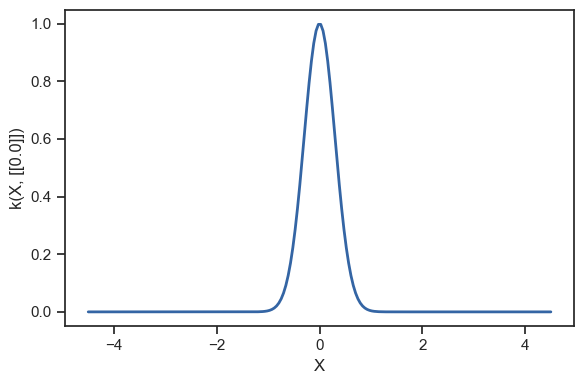

In [2]:
# Import the GPy module:
import GPy
# The input dimension
dim = 1
# The variance of the covariance kernel
variance = 1.
# The lengthscale of the covariance kernel
ell = 0.3
# Generate the covariance object
k = GPy.kern.RBF(dim, variance=variance, lengthscale=ell)
# Print it
print (k)
# and plot it
k.plot();

## Example 1: Plotting a covariance function
Remember:
> The covariance function $k(x,x')$ measures the similarity of $f(x)$ and $f(x')$.

Here is some code to draw $k(\mathbf{x}, \mathbf{x}'=0)$ in one dimension:

In [3]:
def plot_kernel(variance=1., ell=0.3):
    k = GPy.kern.RBF(
        dim,
        variance=variance,
        lengthscale=ell
    )
    k.plot_covariance()

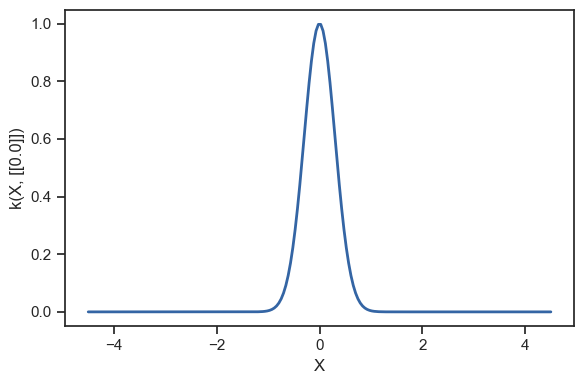

In [4]:
plot_kernel(variance=1.0, ell=0.3)

### Questions
+ What happens as you increase $\ell$?
+ What happens as you decrease $v$?
+ There are many other covariance functions that we could be using. Try changing ``RBF`` to ``Exponential`` in the `plot_kernel()` function. What changes do you nottice?

Now here is some code to plot a 2D covariance function:

In [5]:
def plot_kernel_2d(variance=1., ell1=0.3, ell2=0.3):
    k = GPy.kern.RBF(
        2,
        ARD=True,
        variance=variance,
        lengthscale=[ell1, ell2]
    )
    k.plot_covariance()

You can use it like this:

 /opt/homebrew/lib/python3.9/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


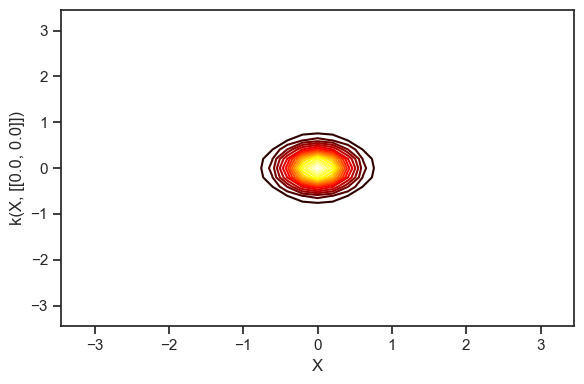

In [6]:
plot_kernel_2d(variance=1.0, ell1=0.3, ell2=0.3)

### Questions
+ What happens as you increase $\ell$?
+ What happens as you decrease $v$?
+ Try a couple of other covariances, e.g., ``Matern32``, ``Matern52``.

## Example 2: Properties of the covariance matrix
Let $\mathbf{x}_{1:n}$ be an arbitrary set of input points. The covariance matrix $\mathbf{K}\in\mathbb{R}^{n\times n}$ defined by:

$$
\mathbf{K}\equiv\mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) = \left(
\begin{array}{ccc}
k(\mathbf{x}_1,\mathbf{x}_1) & \dots & k(\mathbf{x}_1, \mathbf{x}_n)\\
\vdots & \ddots & \vdots\\
k(\mathbf{x}_n, \mathbf{x}_1) & \dots & k(\mathbf{x}_n, \mathbf{x}_n)
\end{array}
\right),
$$

must be [positive definite](https://en.wikipedia.org/wiki/Positive-definite_matrix). Mathematically this can be expressed in two equivalent ways:

+ For all vectors $\mathbf{v}\in\mathbb{R}^T$, we have:

$$
\mathbf{v}^t\mathbf{K}\mathbf{v} > 0,
$$

+ All the eigenvalues of $\mathbf{K}$ are positive.

### Questions
Using the code provided:
+ Verify that the the sum of two covariance functions is a valid covariance function.
+ Verify that the product of two covariance functions is a valid covariance function.
+ Is the following function a covariance function:

$$
k(x, x') = k_1(x, x')k_2(x, x') + k_3(x, x') + k_4(x, x'),
$$

where all $k_i(x, x')$'s are covariance functions.
+ What about:

$$
k(x, x') = k_1(x, x') / k_2(x, x')?
$$

> plotting eigenvalues of K
> they must all be positive


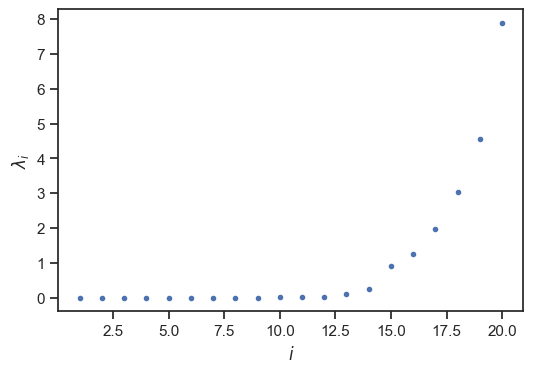

In [7]:
# Number of dimensions
dim = 1

# Number of input points
n = 20

# The lengthscale
ell = .1

# The variance 
variance = 1.

# The covariance function
k1 = GPy.kern.RBF(dim, lengthscale=ell, variance=variance)

# Draw a random set of inputs points in [0, 1]^dim
X = np.random.rand(n, dim)

# Evaluate the covariance matrix on these points
K = k1.K(X)

# Compute the eigenvalues of this matrix
eig_val, eig_vec = np.linalg.eigh(K)

# Plot the eigenvalues (they should all be positive)
print ('> plotting eigenvalues of K')
print ('> they must all be positive')

fig, ax = plt.subplots()
ax.plot(np.arange(1, n+1), eig_val, '.')
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$');

Now create another covariance function:

In [8]:
k2 = GPy.kern.RBF(dim, lengthscale=0.1, variance=1.5)

Create a new covariance function that is the sum of $k_1$ and $k_2$:

In [9]:
k_new = k1 + k2

If this is a valid covariance function, then it must be positive definite.
Let's test it:

> plotting eigenvalues of K
> they must all be positive


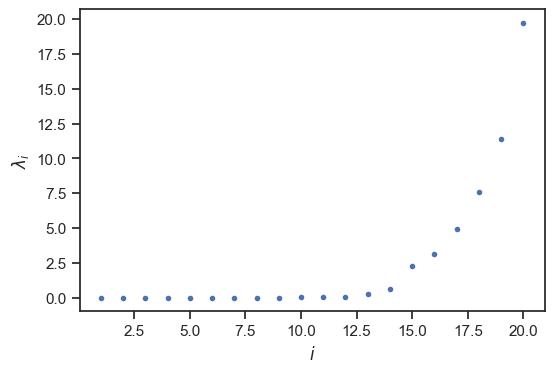

In [10]:
# Compute the covariance matrix:
K_new = k_new.K(X)

# and its eigenvalues
eig_val_new, eig_vec_new = np.linalg.eigh(K_new)

# Plot the eigenvalues (they should all be positive)
print ('> plotting eigenvalues of K')
print ('> they must all be positive')

fig, ax = plt.subplots()
ax.plot(np.arange(1, n+1), eig_val_new, '.')
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$');

## Example 3: Sampling from a Gaussian process

Samples from a Gaussian process are functions. But, functions are infinite dimensional objects?
We cannot sample directly from a GP....
However, if we are interested in the values of $f(\cdot)$ at any given set of test points $\mathbf{x}_{1:n} = \{\mathbf{x}_1,\dots,\mathbf{x}_b\}$, then we have that:

$$
\mathbf{f} | \mathbf{x}_{1:n} \sim \mathcal{N}\left(\mathbf{m}(\mathbf{x}_{1:n}), \mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) \right),
$$

where all the quantities have been introduced above.
This is
What we are going to do is pick a dense set of points $\mathbf{x}_{1:n}\in\mathbb{R}^{n\times d}$
sample the value of the GP, $\mathbf{f} = (f(\mathbf{x}_1),\dots,f(\mathbf{x}_n))$ on these points.
We saw above that the probability density of $\mathbf{f}$ is just a multivariate normal
with a mean vector that is specified from the mean function and a covariance matrix
that is specified by the covariance function.
Therefore, all we need to know is how to sample from the multivariate normal.
This is how we do it:
+ Compute the Cholesky of $\mathbf{L}$:

$$
\mathbf{K} = \mathbf{L}\mathbf{L}^T.
$$

+ Draw $n$ random samples $\mathbf{z} = (z_1,\dots,z_n)$ independently from a standard normal.
+ Get one sample by:

$$
\mathbf{f} = \mathbf{m} + \mathbf{L}\mathbf{z}.
$$

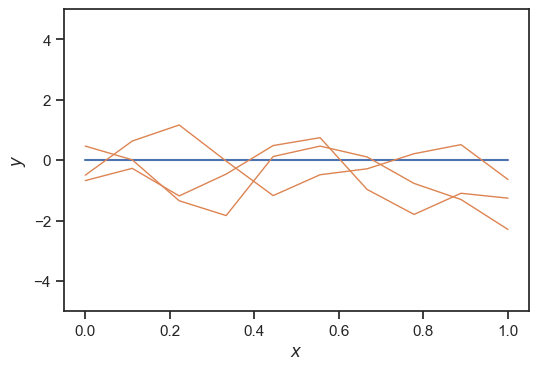

In [11]:
# To gaurantee reproducibility
np.random.seed(123456)

# Number of test points
num_test = 10

# Pick a covariance function
k = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=.1)

# Pick a mean function
mean_func = lambda x: np.zeros(x.shape)

# Pick a bunch of points over which you want to sample the GP
X = np.linspace(0, 1, num_test)[:, None]

# Evaluate the mean function at X
m = mean_func(X)

# Compute the covariance function at these points
nugget = 1e-6 # This is a small number required for stability
C = k.K(X) + nugget * np.eye(X.shape[0])

# Compute the Cholesky of the covariance
# Notice that we need to do this only once
L = np.linalg.cholesky(C)

# Number of samples to take
num_samples = 3

# Take 3 samples from the GP and plot them:
fig, ax = plt.subplots()
# Plot the mean function
ax.plot(X, m)
for i in range(num_samples):
    z = np.random.randn(X.shape[0], 1)    # Draw from standard normal
    f = m + np.dot(L, z)                  # f = m + L * z
    ax.plot(X, f, color=sns.color_palette()[1], linewidth=1)
#ax.set_ylim(-6., 6.)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_ylim(-5, 5);

The solid line is the mean function and the dashed lines are 3 samples of   f . These don’t look like functions yet. This is because we have used only 10 test points to represent the GP.

### Questions

+ Edit the code above changing the number of test points ``num_test`` to 20, 50, 100. Rerun the example. How do your samples of   f look like now? Do they look more like functions to you? Imagine that the true nature of the GP appears when these test points become infinitely dense.

+ Edit the code above and change the random seed to an arbitrary integer (just make up one). Rerun the example and notice how the sampled functions change.

+ Edit the code above and change the variance first to 0.1 and then to 5 each time rerunning the example. Notice the values on the vertical axis of the plot. What happens to the sampled functions as you do this? What does the variance parameter of the SE control?

+ Edit the code above and now change the length-scale parameter first to 0.05 and then to 1. What happens to the sampled functions as you do this? What does the length- scale parameter of the SE control?

+ Now set the variance and the length-scale back to their original values (1. and 0.1, respectively). Edit the code and change the mean function to:
```
     mean_fun = lambda(x): 5 * x
```
Re-run the example. What do you observe? Try a couple more. For example, try:
```
     mean_fun = lambda(x): np.sin(5 * np.pi * x)
```

+ So far, all the samples we have seen are smooth. There is this theorem that says that the samples of the GP will be as smooth as the covariance function we use. Since the SE covariance is infinitely smooth, the samples we draw are infinitely smooth. The [Matern 3-2 covariance function](https://en.wikipedia.org/wiki/Matérn_covariance_function) is twice differentiable. Edit the code and
change ``RBF`` to ``Matern32``. Rerun the example. How smooth are the samples now?

+ The exponential covariance function is continuous but not differentiable. Edit the code and change ``RBF`` to ``Exponential``. Rerun the example. How smooth are the samples now?

+ The covariance function can also be used to model invariances. The periodic exponential covariance function is... a periodic covariance function. Edit line 29 and change ``RBF`` to 
```
k = GPy.kern.PeriodicMatern32(input_dim=1, variance=500., lengthscale=0.01, period=0.1)
```
Rerun the example. Do you notice the periodic pattern?

+ How can you encode the information that there are two lengthscales in $f(\cdot)$. There are many ways to do this.
Try summing or multiplying covariance functions.

:::{note}
The code above does scales as $N^2$ where $N$ is the number of test points.
The memory requirements is similar.
So, it is not efficient to sample like this when $N$ is bigger than 2,000.
In that case, we have to resort to approximate techniques.
In particular, there are some neat techniques developed by A. Wilson from NYU.
See https://gpytorch.ai if you want to learn more.
:::